### Importing Data

In [2]:
!mkdir -p data/
!cd data/
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
!unzip emotion-recognition-dataset.zip
!rm emotion-recognition-dataset.zip
!mv dataset data/
!mv data.csv data/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
from keras.utils import load_img, img_to_array
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data Preprocessing Steps: Repitition from Preprocessing notebook

In [4]:
# ----------------------------------------------------------------------
# remove ahegao folder and records from labels
# ----------------------------------------------------------------------


def remove_emotion_folder(dataset_folder_path, emotion, labels_csv_file):
    emotion_folder = os.path.join(dataset_folder_path, emotion)

    if os.path.exists(emotion_folder):
        shutil.rmtree(emotion_folder)
        print(f"Removed [{emotion}] folder.")

    # Filter out rows with 'ahegao' in the 'emotion' column
    df = pd.read_csv(labels_csv_file)
    df = df[df['label'] != emotion]
    df.to_csv(labels_csv_file, index=False)

    print(f"Removed [{emotion}] records from the CSV file.")
    return None



def flatten_data_folder(dataset_folder_path):
    # Create a new folder to store the flattened images
    flattened_folder_path = os.path.join(dataset_folder_path)
    os.makedirs(flattened_folder_path, exist_ok=True)

    # Iterate through each emotion subfolder
    for emotion_folder in os.listdir(dataset_folder_path):
        emotion_folder_path = os.path.join(dataset_folder_path, emotion_folder)

        # Skip if the path is not a directory
        if not os.path.isdir(emotion_folder_path):
            continue

        # Iterate through each image file in the emotion subfolder
        for image_file in os.listdir(emotion_folder_path):
            image_file_path = os.path.join(emotion_folder_path, image_file)
            destination_path = os.path.join(flattened_folder_path, image_file)

            # Skip if this image has already been copied to the root destination folder
            if os.path.exists(destination_path):
                continue

            # Copy the image file to the root folder
            shutil.copy(image_file_path, destination_path)

        # Finally, remove the emotion folder
        if os.path.isdir(emotion_folder_path):
            shutil.rmtree(emotion_folder_path)
            print(f"Moved images from '{emotion_folder}' folder into {flattened_folder_path}.")
    return None

def get_image_dim(image_path):
    with Image.open(image_path) as img:
        return img.size # returns (width, height)


def add_pixel_dimensions(df):
    """ Adds columns for image pixel width and pixel height for each image
        in the labels dataframe.
    """
    # for error catching in case you run this twice
    if 'width' in df.columns and 'height' in df.columns:
        df = df.drop(columns=['width', 'height'])

    image_folder_path = os.path.join('data', 'dataset')
    widths = []
    heights = []

    # use tqdm to make a progress bar while it works through the df (without the timer part of the bar)
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_path = os.path.join(image_folder_path, row['path'])
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                dims = img.size
                widths.append(dims[0])
                heights.append(dims[1])
        else:
            widths.append(None)
            heights.append(None)
            print(f"Warning: Image not found at {image_path}")
    df['width'] = widths
    df['height'] = heights
    print(" -> Finished adding image dimensions to the dataframes.")

    return df

def encode_label(df, encoder_dict):
    """returns df where label column is encoded"""
    df['label_encoded'] = df['label'].map(encoder_dict)
    return df


def clean_up_labels_file(file_path: str, label_dict):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Modify the 'path' column to exclude everything before the '/'
    df['path'] = df['path'].apply(lambda x: x.split('/', 1)[1] if x.find('/') != -1 else x)

    # drop the unused index column
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # add image width and height
    df = add_pixel_dimensions(df)

    # encode the labels as
    df = encode_label(df, label_dict)

    # crate a new labels csv file
    df.to_csv(file_path, index=False)
    return None



def isolate_cropped_images(input_file_path: str, output_file_path: str):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(input_file_path)

    # only include the cropped images (they all have "cropped_emotion" in the filename)
    df = df[df['path'].str.contains('cropped_emotion')]

    # crate a new labels csv file
    df.to_csv(output_file_path, index=False)
    return None


In [5]:
# ----------------------------------------------------------
# Define the path to the dataset and the CSV file

IMAGES_FOLDER_PATH = os.path.join('data', 'dataset')
LABELS_PATH_full = os.path.join('data', 'data.csv')
LABELS_PATH = os.path.join('data', 'data_cropped.csv')

LABEL_ENCODE_DICT = {
    'Happy': 0,
    'Sad': 1,
    'Angry': 2,
    'Surprise': 3,
    'Neutral': 4
}
# reverse of the label_encode_dict
LABEL_DECODE_DICT = {v: k for k, v in LABEL_ENCODE_DICT.items()}

# ----------------------------------------------------------

In [6]:
# call functions to clean up dataset

remove_emotion_folder(IMAGES_FOLDER_PATH, 'Ahegao', LABELS_PATH_full)
#remove_emotion_folder(IMAGES_FOLDER_PATH, 'Neutral', LABELS_PATH_full)

flatten_data_folder(IMAGES_FOLDER_PATH)

clean_up_labels_file(LABELS_PATH_full, LABEL_ENCODE_DICT) # Note this step takes a while as it opens every image file to record its dimensions.

isolate_cropped_images(LABELS_PATH_full, LABELS_PATH)


Removed [Ahegao] folder.
Removed [Ahegao] records from the CSV file.
Moved images from 'Neutral' folder into data/dataset.
Moved images from 'Sad' folder into data/dataset.
Moved images from 'Angry' folder into data/dataset.
Moved images from 'Happy' folder into data/dataset.
Moved images from 'Surprise' folder into data/dataset.


100%|██████████| 14248/14248 [00:03<00:00, 3674.22it/s]


 -> Finished adding image dimensions to the dataframes.


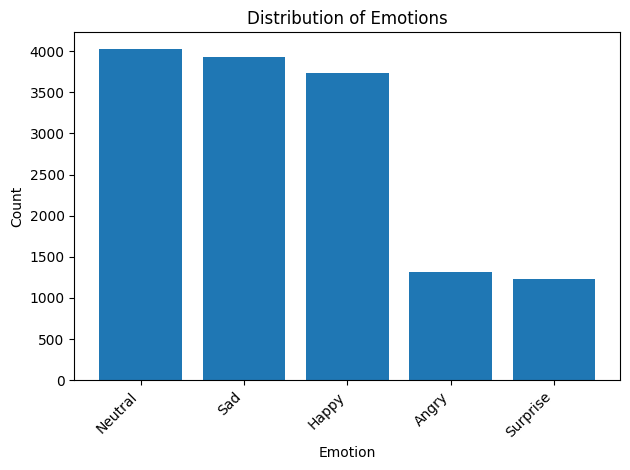


TOTAL IMAGES: 14248
label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Name: count, dtype: int64


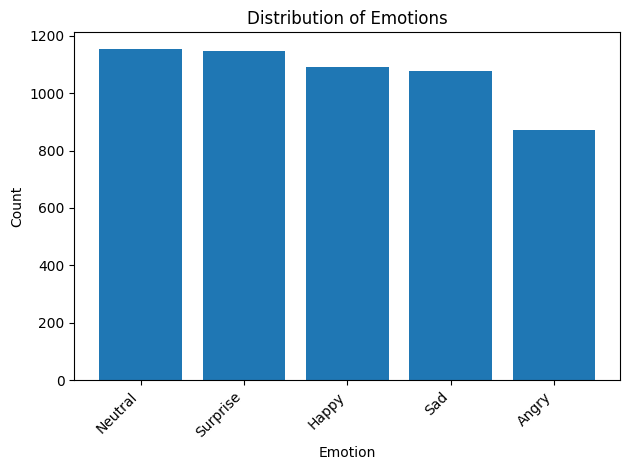


TOTAL IMAGES: 5337
label
Neutral     1154
Surprise    1147
Happy       1090
Sad         1076
Angry        870
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt

def show_class_distribution(labels_csv_path):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(labels_csv_path)

    # Count the occurrences of each emotion
    emotion_counts = df['label'].value_counts()

    # Create a bar chart
    plt.bar(emotion_counts.index, emotion_counts.values)
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title(f'Distribution of Emotions')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

    return emotion_counts


# Call the function to show the class distribution
emotion_counts = show_class_distribution('data/data.csv')
print("\nTOTAL IMAGES:", sum(emotion_counts))
print(emotion_counts)

emotion_counts_cropped = show_class_distribution('data/data_cropped.csv')
print("\nTOTAL IMAGES:", sum(emotion_counts_cropped))
print(emotion_counts_cropped)


In [6]:
# print this out as a reminder:

print(f"{IMAGES_FOLDER_PATH = }")
print(f"{LABELS_PATH_full = }")
print(f"{LABELS_PATH = }")

IMAGES_FOLDER_PATH = 'data/dataset'
LABELS_PATH_full = 'data/data.csv'
LABELS_PATH = 'data/data_cropped.csv'


In [7]:
# create a dataframe for the labels (y)
labels = pd.read_csv(LABELS_PATH)
labels.head()

,path,label,width,height,label_encoded
0,cropped_emotions.100096~12fffff.png,Surprise,224,272,3
1,cropped_emotions.260779~12fffff.png,Surprise,215,357,3
2,cropped_emotions.263616~12fffff.png,Surprise,381,493,3
3,cropped_emotions.263141~12fffff.png,Surprise,74,135,3
4,cropped_emotions.100252~12fffff.png,Surprise,159,194,3


In [8]:

# ----------------------------------------
# 4:3 ratio
# IMAGE_SIZE = (160, 120)

# 3:2 ratio
IMAGE_SIZE = (180, 120)
# ----------------------------------------

def image_crop_and_resize(image_array, target_size):
    """
    Crop and resize an image (input as an array) to a target size.
    """
    # Calculate cropping dimensions to maintain the target aspect ratio
    h1, w1 = image_array.shape[0], image_array.shape[1]
    target_aspect = target_size[1] / target_size[0]
    aspect = w1 / h1

    if aspect > target_aspect:
        new_width = int(target_aspect * h1)
        new_height = h1
    else:
        new_width = w1
        new_height = int(w1 / target_aspect)

    # Calculate cropping box
    left = (w1 - new_width) // 2
    top = (h1 - new_height) // 2
    right = left + new_width
    bottom = top + new_height

    # Crop the image
    image_cropped = tf.image.crop_to_bounding_box(image_array, top, left, new_height, new_width)

    # Resize the cropped image
    image_resized = tf.image.resize(image_cropped, target_size)
    return image_resized


def preprocess_data_part1(labels_df, IMAGE_PATH, target_size = IMAGE_SIZE):
    """
    Generate lists of croppe and resized images (as numpy arrays) and labels.

    Params:
    -------
    IMAGE_PATH (str): Path to directory with the images.
    labels_df (pd.DataFrame): Dataframe with labels and paths to images.

    Returns:
    --------
    X (np.ndarray): Array of keras img objects. Images of shape (N, target_height, target_width, 3)
    y (np.ndarray): Labels of shape (N,)
    """
    images = []
    labels = []

    # Create lists of images and labels
    for idx, row in labels_df.iterrows():
        img_path = row['path']
        label = row['label_encoded']

        # Add label to y list
        labels.append(label)

        # Read image
        img = load_img(os.path.join(IMAGE_PATH, img_path))
        img_array = img_to_array(img)

        # call my custom function to crop and resize the image
        img_array = image_crop_and_resize(img_array, target_size=target_size)

        # Append to images list
        images.append(img_array)

    # Stack images and transform into an array
    images = np.stack(images)
    labels = np.array(labels).flatten()

    return images, labels


In [17]:
X, y = preprocess_data_part1(labels, IMAGES_FOLDER_PATH)

print(f"X (images) shape {X.shape}")
print(f"y shape {y.shape}")

X (images) shape (5337, 180, 120, 3)
y shape (5337,)


In [10]:
print(y)

[3 3 3 ... 2 2 2]


In [18]:
def data_split_and_augment(images, labels, splits):
    """ Split data into train, validation and test sets; apply augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """

    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    idx = np.random.permutation(images.shape[0])
    images, labels = images[idx], labels[idx]

    # create data splits (training, val, and test sets)
    split_points = [int(splits[0] * len(images)), int((splits[0]+splits[1]) * len(images))]
    X_train, X_val, X_test = np.split(images, [split_points[0], split_points[1]])
    y_train, y_val, y_test = np.split(labels, [split_points[0], split_points[1]])

    # image augmentation (random flip) on training data
    X_train_augm = tf.image.random_flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data (will double the count of images)
    X_train = tf.concat([X_train, X_train_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    # y_train = tf.concat([y_train, y_train],axis=0)
    y_train = np.concatenate([y_train, y_train], axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle) # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle) # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test


# define splits
split = (0.6, 0.2, 0.2)
X_train, y_train, X_val, y_val, X_test, y_test = data_split_and_augment(X, y, split)


print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")



X_train shape (6404, 180, 120, 3)
y_train shape (6404,)
X_val shape (1067, 180, 120, 3)
y_val shape (1067,)
X_test shape (1068, 180, 120, 3)
y_test shape (1068,)


In [12]:
# delete the X and Y arrays to free up more space in RAM
del X
del y

In [19]:
print(y_train)

tf.Tensor([1 4 1 ... 1 4 1], shape=(6404,), dtype=int64)


# Creating the CNN models and Hypertuning

In [37]:

# Define the basic CNN model
def create_basic_cnn_model(input_shape):
    model = Sequential()

    # Convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

    # Max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(units=128, activation='relu'))

    # Output layer
    model.add(Dense(units=5, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model


input_shape = (180, 120, 3)

# Create and summarize the basic CNN model
basic_cnn_model = create_basic_cnn_model(input_shape)
basic_cnn_model.summary()

# Train the basic CNN model
history_basic = basic_cnn_model.fit(X_train, y_train,
                                    epochs=3,
                                    batch_size=32,
                                    validation_data=(X_val, y_val),
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


train_loss, train_accuracy = basic_cnn_model.evaluate(X_train, y_train)
val_loss, val_accuracy = basic_cnn_model.evaluate(X_val, y_val)

print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)
print("Val loss:", val_loss)
print("Val accuracy:", val_accuracy)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 178, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 89, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 168032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │      21,508,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,509,765 (82.05 MB)

 Trainable params: 21,509,765 (82.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
201/201 ━━━━━━━━━━━━━━━━━━━━ 184s 908ms/step - accuracy: 0.3018 - loss: 3.0148 - val_accuracy: 0.4724 - val_loss: 1.3226
Epoch 2/2
201/201 ━━━━━━━━━━━━━━━━━━━━ 198s 886ms/step - accuracy: 0.5709 - loss: 1.1171 - val_accuracy: 0.5098 - val_loss: 1.2435
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.7477 - loss: 0.7882
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5264 - loss: 1.2408
Training loss: 0.7863708734512329
Training accuracy: 0.750312328338623
Val loss: 1.243544101715088
Val accuracy: 0.5098406672477722


In [27]:
def create_complex_cnn_model(input_shape):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Flattening layer
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=5, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model


input_shape = (180, 120, 3)

# Create and summarize the more complex CNN model
complex_cnn_model = create_complex_cnn_model(input_shape)
complex_cnn_model.summary()

# Train the complex CNN model
history_complex = complex_cnn_model.fit(X_train, y_train,
                                        epochs=5,
                                        batch_size=25,
                                        validation_data=(X_val, y_val),
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


train_loss2, train_accuracy2 = complex_cnn_model.evaluate(X_train, y_train)
val_loss2, val_accuracy2 = complex_cnn_model.evaluate(X_val, y_val)

print("Training loss:", train_loss2)
print("Training accuracy:", train_accuracy2)
print("Val loss:", val_loss2)
print("Val accuracy:", val_accuracy2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 178, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 178, 118, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 89, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 89, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 87, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 87, 57, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 43, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 43, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 41, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 41, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 20, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 33280)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       4,259,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,757 (16.61 MB)

 Trainable params: 4,354,309 (16.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.2121 - loss: 28.4082 - val_accuracy: 0.1987 - val_loss: 1.6187
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.2168 - loss: 1.8124 - val_accuracy: 0.2062 - val_loss: 1.6027
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.2104 - loss: 1.6034 - val_accuracy: 0.2071 - val_loss: 1.6020
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.2123 - loss: 1.6139 - val_accuracy: 0.2062 - val_loss: 1.6050
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.2151 - loss: 1.6051 - val_accuracy: 0.1996 - val_loss: 1.6065
201/201 ━━━━━━━━━━━━━━━━━━━━ 88s 440ms/step - accuracy: 0.2252 - loss: 1.5996
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.2240 - loss: 1.6027
Training loss: 1.6008092164993286
Training accuracy: 0.22001874446868896
Val loss: 1.60200035572052
Val accuracy: 0.2071227729320526


# Generalization and Confusion Matrix

In [38]:
#Evaluating the basic model

test_loss_basic, test_acc_basic = basic_cnn_model.evaluate(X_test, y_test)
print(f"Basic CNN Model Test Accuracy: {test_acc_basic:.4f}")

# Evaluate the complex model
test_loss_complex, test_acc_complex = complex_cnn_model.evaluate(X_test, y_test)
print(f"Complex CNN Model Test Accuracy: {test_acc_complex:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.4656 - loss: 1.3225
Basic CNN Model Test Accuracy: 0.4850
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - accuracy: 0.2100 - loss: 1.6024
Complex CNN Model Test Accuracy: 0.2069


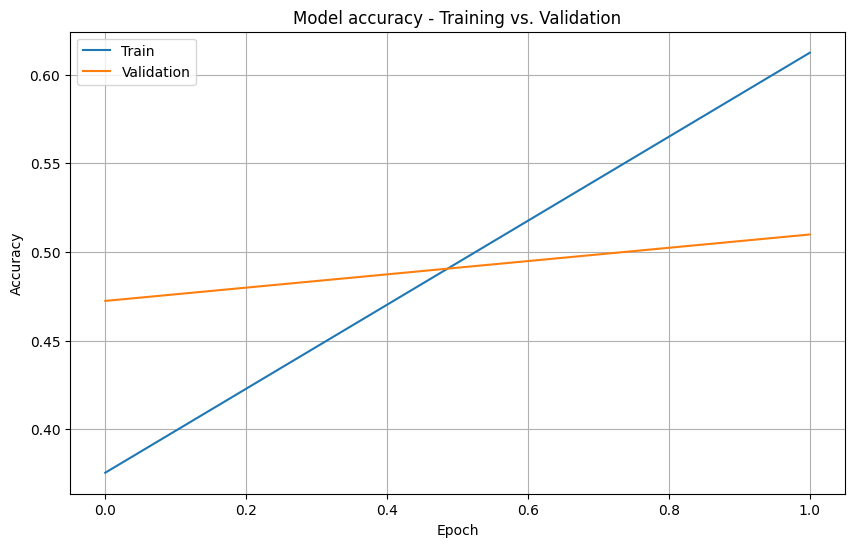

In [39]:

def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - Training vs. Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.show()

plot_accuracy(history_basic)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step


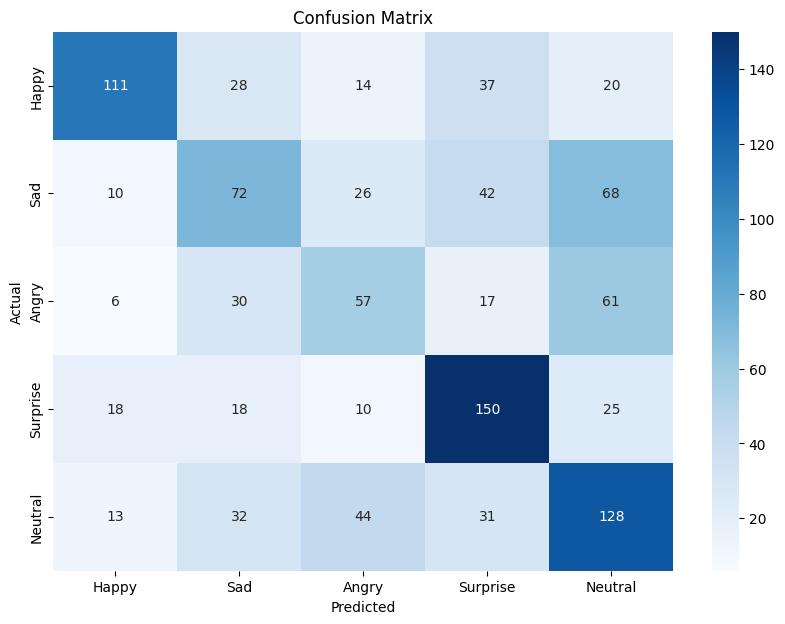

In [40]:
LABEL_DECODE_DICT = {v: k for k, v in LABEL_ENCODE_DICT.items()}

# Predict the labels for the test set
y_pred = np.argmax(basic_cnn_model.predict(X_test), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_DECODE_DICT.values(), yticklabels=LABEL_DECODE_DICT.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()